# 19 FBS decoupling with SVT
This tutorial shows the application of the singular vector transformation to perform substructure decoupling in the classic LM-FBS framework. The operations are performed with experimentally obtained FRFs.

In [1]:
import pyFBS

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Data Import
Load the required predefined datasets:

In [2]:
pyFBS.download_lab_testbench()

100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 7015.56it/s]

In [3]:
stl_dir_A = r"./lab_testbench/STL/A.stl"
stl_dir_B = r"./lab_testbench/STL/B.stl"
stl_dir_AB = r"./lab_testbench/STL/AB.stl"

exp_A = r"./lab_testbench/Measurements/Y_A.p"
exp_B = r"./lab_testbench/Measurements/Y_B.p"
exp_AB = r"./lab_testbench/Measurements/Y_AB.p"

pos_xlsx = r"./lab_testbench/Measurements/decoupling_example_SVT.xlsx"

df_acc_A = pd.read_excel(pos_xlsx, sheet_name='Sensors_A')
df_chn_A = pd.read_excel(pos_xlsx, sheet_name='Channels_A')
df_imp_A = pd.read_excel(pos_xlsx, sheet_name='Impacts_A')

df_acc_B = pd.read_excel(pos_xlsx, sheet_name='Sensors_B')
df_chn_B = pd.read_excel(pos_xlsx, sheet_name='Channels_B')
df_imp_B = pd.read_excel(pos_xlsx, sheet_name='Impacts_B')

df_acc_AB = pd.read_excel(pos_xlsx, sheet_name='Sensors_AB')
df_chn_AB = pd.read_excel(pos_xlsx, sheet_name='Channels_AB')
df_imp_AB = pd.read_excel(pos_xlsx, sheet_name='Impacts_AB')

## 3D view
Open 3D viewer in the background. With the 3D viewer the subplot capabilities of [PyVista](https://docs.pyvista.org/index.html) can be used.

In [4]:
view3D = pyFBS.view3D(show_origin = False, show_axes = False,shape =  (1,3),title = "Overview")

Add the STL file of substructure A to the 1-1 subplot and show the corresponding accelerometers, channels and impacts.

In [5]:
view3D.plot.subplot(0,0)
view3D.plot.isometric_view()
view3D.plot.add_text("A structure", position='upper_left', font_size=10, color="k", font="times", name="A_structure")

view3D.add_stl(stl_dir_A,color = "#83afd2",name = "A");
view3D.show_acc(df_acc_A,scale = 1000)
view3D.show_imp(df_imp_A,scale = 1000)
view3D.show_chn(df_chn_A,scale = 1000)

Add the STL file of substructure B to the 1-2 subplot and show the corresponding accelerometers, channels and impacts.

In [6]:
view3D.plot.subplot(0,1)
view3D.plot.isometric_view()
view3D.plot.add_text("B structure", position='upper_left', font_size=10, color="k", font="times", name="B_structure");

view3D.add_stl(stl_dir_B,color = "#83afd2",name = "B");
view3D.show_acc(df_acc_B,scale = 1000,overwrite = False)
view3D.show_imp(df_imp_B,scale = 1000,overwrite = False)
view3D.show_chn(df_chn_B,scale = 1000,overwrite = False)

Add STL file of the assembly AB to the 1-3 subplot and show the corresponding reference accelerometers, channels and impacts.

In [7]:
view3D.plot.subplot(0,2)
view3D.plot.isometric_view()
view3D.plot.add_text("AB structure", position='upper_left', font_size=10, color="k", font="times", name="AB_structure");

view3D.add_stl(stl_dir_AB,color = "#83afd2",name = "AB");
view3D.show_acc(df_acc_AB,scale = 1000,overwrite = False)
view3D.show_imp(df_imp_AB,scale = 1000,overwrite = False)
view3D.show_chn(df_chn_AB,scale = 1000,overwrite = False)

Each separate subplot view can also be linked or unlinked:

In [8]:
view3D.plot.link_views()
#view3D.plot.unlink_views()

## Experimental model

In [9]:
freq, _Y_A_exp = np.load(exp_A, allow_pickle = True)
_, _Y_B_exp = np.load(exp_B, allow_pickle = True)
_, _Y_AB_exp = np.load(exp_AB, allow_pickle = True)

Y_A_exp = np.transpose(_Y_A_exp, (2, 0, 1))
Y_B_exp = np.transpose(_Y_B_exp, (2, 0, 1))
Y_AB_exp = np.transpose(_Y_AB_exp, (2, 0, 1))



## Singular vector transformation 
The SVT can be performed directly on the measured data. Make sure that input and output DoFs involved in the transformation are the same in the subsystem to be decoupled (B) and the assembled system (AB). Furthermore, the same reduction spaces must be used for both the systems (B and AB) in order to guarantee a proper compatibility and equilibrium. The reduced singular subspaces are extracted from the subsystem B and a number of 6 DoFs is used.

In [10]:
k = 6
svt = pyFBS.SVT(df_chn_B,df_imp_B,freq,Y_B_exp,[1,10],k)


Apply the defined SVT to systems B and AB:

In [11]:
_,_,FRF_B_sv= svt.apply_SVT(df_chn_B,df_imp_B,freq,Y_B_exp)
_,_,FRF_AB_sv= svt.apply_SVT(df_chn_AB,df_imp_AB,freq,Y_AB_exp)


## LM-FBS Decoupling

The uncoupled global admittance is constructed using the transformed FRF datasets and imposing the decoupling operation through the minus sign. The compatibility and the equilibrium conditions are defined via the signed Boolean matrices.

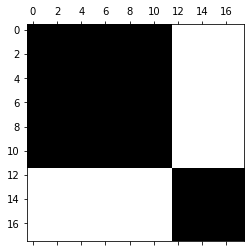

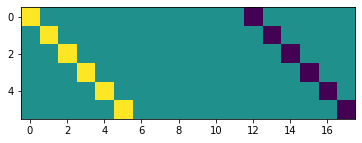

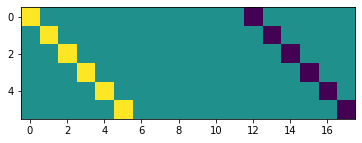

In [12]:
Y_AB_un = np.zeros((len(freq),2*k+6,2*k+6),dtype = complex)

Y_AB_un[:,0:2*k,0:2*k] = FRF_AB_sv
Y_AB_un[:,2*k:,2*k:] = -1*FRF_B_sv

plt.spy(np.abs(Y_AB_un[100]))

Bu = np.zeros((k,2*k+6))
Bu[:k,0:k] = 1*np.eye(k)
Bu[:k,2*k:2*k+6] = -1*np.eye(k)

plt.figure()
plt.imshow(Bu)

Bf = Bu

plt.figure()
plt.imshow(Bf)


Apply the LM-FBS based on the defined compatibility and equilibrium conditions.

In [13]:
Y_A_dec = np.zeros_like(Y_AB_un,dtype = complex)

Y_int = Bu@Y_AB_un@Bf.T
Y_A_dec  = Y_AB_un - Y_AB_un@Bf.T@np.linalg.pinv(Y_int)@Bu@Y_AB_un


## Results
First extract the FRFs at the reference DoFs:

In [14]:
arr_ = [6,7,8,9,10,11]
Y_A_LMFBS = Y_A_dec[:,arr_,:][:,:,arr_]
Y_A_ref = Y_A_exp

The decoupled and the reference results for A can be compared:

,Name,Description,Quantity,Grouping,Position_1,Position_2,Position_3,Direction_1,Direction_2,Direction_3
1,S1 Y,NaN,NaN,10,-0.076519,0.142987,0.022,-0.70915,0.705057,0


,Name,Description,Quantity,Grouping,Position_1,Position_2,Position_3,Direction_1,Direction_2,Direction_3
0,H1,NaN,NaN,10,0.014311,0.207959,0.017,5.790274e-10,0.0,-1


(0.0, 2000.0)

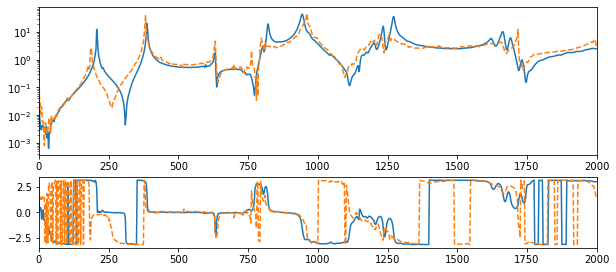

In [15]:
s1 = 1
s2 = 0

display(df_chn_A.loc[[s1]])
display(df_imp_A.loc[[s2]])

plt.figure(figsize = (10,6))
plt.subplot(211)
plt.semilogy(freq,np.abs(Y_A_ref[:,s1,s2]),label = "reference")
plt.semilogy(freq,np.abs(Y_A_LMFBS[:,s1,s2]),'--',label = "LMFBS decoupled")

plt.xlim(0,2000)

plt.subplot(413)
plt.plot(freq,np.angle(Y_A_ref[:,s1,s2]),label = "reference")
plt.plot(freq,np.angle(Y_A_LMFBS[:,s1,s2]),'--',label = "LMFBS decoupled")

plt.xlim(0,2000)